[![assembled circuit](https://img.youtube.com/vi/COsEE_Mif4k/0.jpg)](https://www.youtube.com/watch?v=COsEE_Mif4k)

🎥Link to the video : https://www.youtube.com/watch?v=COsEE_Mif4k

## Introduction
This notebook is part of my work on creating speech recognition system on microcontrollers like Raspberry Pi Pico running CircuitPython. Please checkout article on my wesbite for more information. 

This notebook uses Speech Commands Dataset  licensed under the [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/):

Warden P. Speech Commands: A public dataset for single-word speech recognition, 2017. Available from http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

## Importing necessary libraries

In [25]:
import random
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf


## Methods for Feature Extraction

Our microcontroller samples audio at approximately 8kHz (`SAMPLE_RATE`) for 1 second, producing an input array of 8192 points. Here's the step-by-step process we use to extract features from this data:

1. **Segmenting the Input**:
   - We add white noise to the recorded audio sample using `NOISE_AMPLITUDE` to adjust intensity of noise.
   - We divide the 8192-point array into segments based on a defined `WINDOW_SIZE`, with no overlap between segments.
   - For example, if `WINDOW_SIZE` is 1024, we get eight segments of 1024 points each.

2. **Calculating FFT**:
   - For each segment, we calculate the Fast Fourier Transform (FFT).
   - The FFT output is also 1024 points long, but since the FFT output is symmetric, we only consider the first half, resulting in 512 points per segment.
   - The first point (DC component) of these 512 points is set to zero.

3. **Downsampling**:
   - A feature vector with 512x8 data points (4096 points) is too large for a microcontroller like the RP2040.
   - To reduce the size, we downsample aggressively by creating 16 bins for each segment, with each bin containing 32 points.
   - We calculate the mean of the 32 points in each bin, reducing each segment to 16(`NUM_BINS`) points.
   - This results in a final feature vector of 16x8 = 128 data points.

By following this method, we effectively reduce the original 8192-point signal to 128 data points, making it manageable for the microcontroller's 256KB RAM while maintaining good performance. This aggressive reduction balances the need for smaller inputs and models with the available resources of CircuitPython and the RP2040.

In [26]:
SAMPLE_RATE = 8192
NOISE_AMPLITUDE = 0.20
WINDOW_SIZE = 1024
NUM_BINS = 16
TRAINING_PHRASE = 'yes'

In [27]:
def downsample_waveform(waveform, num_bins):
    waveform = np.array(waveform)
    original_length = len(waveform)
    points_per_bin = original_length // num_bins
    downsampled_waveform = np.zeros(num_bins)
    for i in range(num_bins):
        start_index = i * points_per_bin
        end_index = start_index + points_per_bin
        downsampled_waveform[i] = waveform[start_index:end_index].mean()
    
    return downsampled_waveform.tolist()

def extract_features(audio_file_path, window_size, overlap,add_noise=True):
    noise_file_path = "/kaggle/input/google-speech-commands/_background_noise_/white_noise.wav"
    target_sample_rate = SAMPLE_RATE

    # Read white noise audio file
    noise_sample_rate, noise_data = wavfile.read(noise_file_path)
    noise_duration = len(noise_data) / noise_sample_rate
    
    # Generate random start time within the noise file
    random_start_time = random.uniform(0, noise_duration - 1)
    random_end_time = random_start_time + 1  # 1-second segment

    # Extract random 1-second segment of white noise
    start_index = int(random_start_time * noise_sample_rate)
    end_index = int(random_end_time * noise_sample_rate)
    random_noise_segment = noise_data[start_index:end_index]

    # Resample white noise segment to target sample rate
    resampled_noise_segment = resample(random_noise_segment, target_sample_rate)
    if add_noise:
        resampled_noise_segment = NOISE_AMPLITUDE * resampled_noise_segment
    else:
        resampled_noise_segment = 0 * resampled_noise_segment

    # Read and resample audio file
    sample_rate, audio_data = wavfile.read(audio_file_path)
    resampled_audio = resample(audio_data, target_sample_rate)

    # Add white noise to the audio
    augmented_audio = resampled_audio + resampled_noise_segment

    step_size = window_size - overlap
    num_windows = (len(augmented_audio) - window_size) // step_size + 1
    fft_results = []

    for i in range(num_windows):
        start_index = i * step_size
        end_index = start_index + window_size
        windowed_signal = augmented_audio[start_index:end_index]
        
        fft_result = np.fft.fft(windowed_signal)
        fft_result = fft_result[0:int(fft_result.shape[0] / 2)]
        fft_magnitude = np.abs(fft_result)
        fft_magnitude[0] = 0
        fft_magnitude = downsample_waveform(fft_magnitude,NUM_BINS)
        fft_results.extend(fft_magnitude)

    return np.array(fft_results)

Let us test out our feature extraction method on a sample file.

In [28]:
f = extract_features("/kaggle/input/google-speech-commands/dog/00b01445_nohash_0.wav", 1024, 0)
print(f.shape)

(128,)


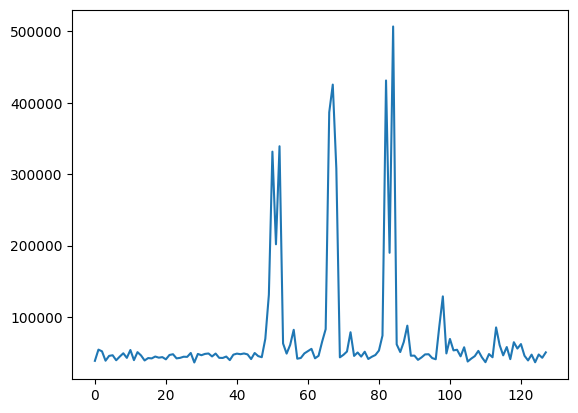

In [29]:
plt.plot(f)

## Generating Test Data

Set the  training phrase  (`TRAINING_PHRASE`) to the word we want to detect. Valid values for 'TRAINING_PHRASE' are:

|      |      |      |       |       |
|------|------|------|-------|-------|
| yes  | no   | up   | down  | left  |
| right| on   | off  | stop  | go    |
| zero | one  | two  | three | four  |
| five | six  | seven| eight | nine  |

In [30]:
#overwrite training phrase, by default it is set to "on"
#TRAINING_PHRASE = 'on'

In [31]:
def fetch_random_filename(directories):
    random_directory = random.choice(directories)
    files_in_directory = os.listdir(random_directory)
    random_filename = random.choice(files_in_directory)
    return os.path.join(random_directory, random_filename)

In [32]:
def get_subdirectories(directory):
    subdirectories = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            subdirectories.append(item_path)
    return subdirectories

In [33]:
def load_data_from_folders(folder):
    features = []
    labels = []
    ctr = 0
    all_dirs = get_subdirectories("/kaggle/input/google-speech-commands")
    all_dirs.remove(folder)
    
    # Process left folder
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):  # Assuming the files are .wav
            ctr = ctr + 1
            if ctr%100 ==0:
                print(f"processed {ctr} files")
            file_path = os.path.join(folder, filename)
            f = extract_features(file_path,WINDOW_SIZE,0)
            if f.shape[0] == 128:
                features.append(f)
                labels.append(1)
    
        negative_file = fetch_random_filename(all_dirs)
        if negative_file.endswith(".wav"):
            ctr = ctr + 1
            if ctr%100 ==0:
                print(f"processed {ctr} files")
            f = extract_features(negative_file,WINDOW_SIZE,0)
            if f.shape[0] == 128:
                features.append(f)
                labels.append(0)
                
    return np.array(features),np.array(labels)

# Load data
on_folder = "/kaggle/input/google-speech-commands/"+TRAINING_PHRASE 
X, y = load_data_from_folders(on_folder)

processed 100 files
processed 200 files


/tmp/ipykernel_33/3114625034.py:38: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(audio_file_path)


processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files
processed 4100 files
processed 4200 files
processed 4300 files
processed 4400 files
processed 4500 files
processed 4600 files
processed 4700 files


## Create training and test data

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [36]:
def normalize(array):
    min_val = array.min()
    max_val = array.max()
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array
 
X_train_normalized = [normalize(item) for item in X_train]
X_test_normalized = [normalize(item) for item in X_test]

X_train_normalized = np.array(X_train_normalized)
X_test_normalized = np.array(X_test_normalized)

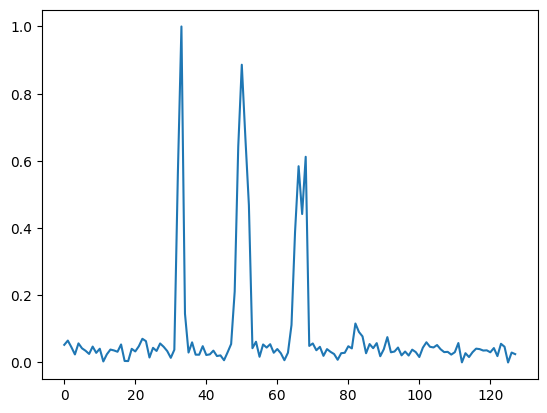

In [37]:
plt.plot(X_train_normalized[0])

## Training a model
We develop a compact dense neural network designed to recognize if the speech contains `TRAINING_PHRASE`. The model exclusively uses `Dense` layers and is intentionally kept small to ensure it can be handled by the microcontroller. Our goal is to achieve an accuracy of 75% or higher on the validation data to ensure the model's usability.
 

In [38]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(12, input_shape=(128,), activation='relu'),
    Dense(8, activation='relu'),  
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661 (6.49 KB)

 Trainable params: 1,661 (6.49 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.fit(X_train_normalized, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5282 - loss: 0.6875 - val_accuracy: 0.5692 - val_loss: 0.6839
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5776 - loss: 0.6802 - val_accuracy: 0.5942 - val_loss: 0.6726
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6359 - loss: 0.6642 - val_accuracy: 0.6232 - val_loss: 0.6602
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6520 - loss: 0.6455 - val_accuracy: 0.6469 - val_loss: 0.6417
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6769 - loss: 0.6234 - val_accuracy: 0.6535 - val_loss: 0.6297
Epoch 6/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6859 - loss: 0.6071 - val_accuracy: 0.6667 - val_loss: 0.6204
Epoch 7/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6876 - loss: 0.5954 - val_accuracy: 0.6561 - val_loss: 0.6161
Epoch 8/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6949 - loss: 0.5833 - val_accuracy: 0.6785 - val_loss:

Let us now try out our model on test data. You should see higher numbers of ✅ and lower number of ❌ or zero .

In [40]:
for idx in range(0,25):
    new_features = X_test_normalized[idx]
    new_features = np.array([new_features])
    prediction = model(new_features) 
    pclass= "something_else" if prediction[0] <0.5 else "on"
    aclass = "something_else" if y_test[idx] == 0 else "on"
    if pclass != aclass:
        print("❌",prediction[0])
    else:
        print("✅",prediction[0])

❌ tf.Tensor([0.31266257], shape=(1,), dtype=float32)
✅ tf.Tensor([0.9252102], shape=(1,), dtype=float32)
❌ tf.Tensor([0.23889151], shape=(1,), dtype=float32)
✅ tf.Tensor([0.6394444], shape=(1,), dtype=float32)
✅ tf.Tensor([0.7636797], shape=(1,), dtype=float32)
✅ tf.Tensor([0.28904274], shape=(1,), dtype=float32)
✅ tf.Tensor([0.38424265], shape=(1,), dtype=float32)
❌ tf.Tensor([0.15086178], shape=(1,), dtype=float32)
✅ tf.Tensor([0.45566788], shape=(1,), dtype=float32)
✅ tf.Tensor([0.0226263], shape=(1,), dtype=float32)
✅ tf.Tensor([0.44681945], shape=(1,), dtype=float32)
✅ tf.Tensor([0.13175984], shape=(1,), dtype=float32)
❌ tf.Tensor([0.2613095], shape=(1,), dtype=float32)
❌ tf.Tensor([0.32838678], shape=(1,), dtype=float32)
✅ tf.Tensor([0.76608205], shape=(1,), dtype=float32)
✅ tf.Tensor([0.4157712], shape=(1,), dtype=float32)
❌ tf.Tensor([0.43989205], shape=(1,), dtype=float32)
✅ tf.Tensor([0.54727703], shape=(1,), dtype=float32)
✅ tf.Tensor([0.7083211], shape=(1,), dtype=float32)


## Export weights and biases to pure python
Now we have a trained model that seems to work well to classify the word of our choice (`TRAINING_PHRASE`). We still have to convert this model to a format which CircuitPython can execute. The easiest way to do this is to export the inference method of the model to 'pure' python code. Since our model is really small and we are only using 'Dense' layers this is kind of easy. We load weights and bias from each layers and create a 'predict' method written in pure python that performs inference on input features and returns results.

In [41]:
weights_and_biases = {}
for i, layer in enumerate(model.layers):
    weights, biases = layer.get_weights()
    weights_and_biases[f'w{i}'] = weights
    weights_and_biases[f'b{i}'] = biases

# Save the weights and biases to a file
np.savez('model_weights_biases.npz', **weights_and_biases)

In [42]:
data = np.load('model_weights_biases.npz')
weights_and_biases = {key: data[key] for key in data}

w0, b0 = weights_and_biases['w0'], weights_and_biases['b0']
w1, b1 = weights_and_biases['w1'], weights_and_biases['b1']
w2, b2 = weights_and_biases['w2'], weights_and_biases['b2']

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict(input_data):
    z1 = np.dot(input_data, w0) + b0
    a1 = relu(z1)

    z2 = np.dot(a1, w1) + b1
    a2 = relu(z2)

    z3 = np.dot(a2, w2) + b2
    output = sigmoid(z3)

    return output

## Exporting our python code to a python file
Next we use some nice hacks to export our code along with weights and biases to a "`{TRAINING_PHRASE}_model.py`" file. Now we have to understand, this this file can be quite large. CircuitPython may have trouble even parsing such a file. So, we use `python-minimizer` tool to reduce the size of this file. Luciky our model is  26Kb in size after minification, just close the max size CircuityPython can load it (Any larger and it may fail loading).

>Note: It should be further possible to reduce size of this model by creating a \*.mpy using [mpy-cross](https://pypi.org/project/mpy-cross/) cross compiler. However I encountered errors when trying this

In [43]:
np.set_printoptions(threshold=np.inf)
def v_to_str(v):
    return repr(v).replace("array","np.array").replace("float32",'np.float')

In [44]:
content = f'''
# This model was trained using Speech Commands Dataset licensed under the Creative Commons BY 4.0 license.
# Warden P. Speech Commands: A public dataset for single-word speech recognition, 2017. 
# Available from http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

from ulab import numpy as np

def _relu(x):
    return np.maximum(0, x)

def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _layer_zero(input_data):
    w0 = {v_to_str(w0)} 
    b0 = {v_to_str(b0)}
    z1 = np.dot(input_data, w0) + b0
    a1 = _relu(z1)
    return a1

def _layer_one(input):
    w1 = {v_to_str(w1)} 
    b1 = {v_to_str(b1)}
    z2 = np.dot(input, w1) + b1
    a2 = _relu(z2)
    return a2

def _layer_three(input):
    w2 = {v_to_str(w2)}
    b2 = {v_to_str(b2)}
    z3 = np.dot(input, w2) + b2
    return _sigmoid(z3)
    
def predict(input_data):
    a = _layer_zero(input_data)
    b = _layer_one(a)
    return _layer_three(b)
'''

In [45]:
with open(f"{TRAINING_PHRASE}_model.py", "w") as file:
    file.write(content)

Let us now compress the model using `python-minimizer`

In [46]:
!pip install python-minimizer

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [47]:
import subprocess
command = ["python-minimizer", f"{TRAINING_PHRASE}_model.py", "-o", f"{TRAINING_PHRASE}_model_min.py"]
subprocess.run(command)
print(f"Successfully generated {TRAINING_PHRASE}_model_min.py")

Successfully generated no_model_min.py


Let us check the size of minified model file

In [48]:
import subprocess
command = ["ls","-alh", f"{TRAINING_PHRASE}_model_min.py"]
subprocess.run(command)

-rw-r--r-- 1 root root 26K May 20 17:13 no_model_min.py


CompletedProcess(args=['ls', '-alh', 'no_model_min.py'], returncode=0)

Thats it ! Now we have trained a new model and a corresponding `\*_model_min.py` file, simply copy this file on your CircuitPython board and import the predict function like this:

```python
from xxx_model_min import predict
```